# 1. Installing Dependencies 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.14 s (started: 2022-12-15 02:05:54 +00:00)


In [ ]:
!pip install tqdm
!pip install stopwords
!pip install nltk 
!pip install tweet-preprocessor

!pip install ipython-autotime
%load_ext autotime

!pip install transformers
!pip3 install torch

from IPython.display import clear_output
clear_output(wait=False)

time: 14.1 s (started: 2022-12-15 02:04:43 +00:00)


In [ ]:
# GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec 15 02:04:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Memory info
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!
time: 1.48 ms (started: 2022-12-15 02:04:58 +00:00)


In [ ]:
import pandas as pd
import numpy as np

import nltk
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import re, string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

from google.colab import drive
drive.mount('/content/drive')

# specify GPU
device = torch.device("cuda")

clear_output(wait=False)

time: 27.5 s (started: 2022-12-15 02:04:58 +00:00)


# 2. Data Preparation for NLP - Twitter Raw dataset

## *i) Import Twitter Raw Dataset 1 and perform EDA*

In [ ]:
# Data Import and loading in Dataframe
path = r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Twitter_dataset_932k_Input.json'
df_raw = pd.read_json(path)

time: 18.4 s (started: 2022-12-13 11:59:18 +00:00)


In [ ]:
# Data Exploration - EDA
df_raw.head()

,id,author_id,edit_history_tweet_ids,text,created_at,lang,author,geo,withheld
0,1594480600211107840,1478956686593253376,[1594480600211107840],@Mikepri62471342 @FinisLDaileyIII @JamesBoonie...,2022-11-20 23:59:33+00:00,en,"{'id': '1478956686593253377', 'name': 'Darryl ...",NaN,NaN
1,1594480568137580544,1325148180544016384,[1594480568137580544],RT @DanReynolds: thinking about all the sensel...,2022-11-20 23:59:26+00:00,en,"{'id': '1325148180544016385', 'location': '⩇⩇:...",NaN,NaN
2,1594480544804380672,15932723,[1594480544804380674],"RT @aaronklemz: So, a straw buyer buys guns on...",2022-11-20 23:59:20+00:00,en,"{'id': '15932723', 'location': 'Minneapolis, M...",NaN,NaN
3,1594480485308444672,1170914021509255168,[1594480485308444672],@nonphinary I hate the damage that game has do...,2022-11-20 23:59:06+00:00,en,"{'id': '1170914021509255168', 'location': 'Par...",NaN,NaN
4,1594480436851666944,780381795602739200,[1594480436851666944],RT @pdxlawgrrrl: Jailing people doesn't keep u...,2022-11-20 23:58:54+00:00,en,"{'id': '780381795602739200', 'location': 'Port...",NaN,NaN


time: 14.5 ms (started: 2022-12-13 11:59:36 +00:00)


In [ ]:
# Dataset Dimensions
print('Shape: ', df_raw.shape)
print('Columns: ', df_raw.columns)

Shape:  (932778, 9)
Columns:  Index(['id', 'author_id', 'edit_history_tweet_ids', 'text', 'created_at',
       'lang', 'author', 'geo', 'withheld'],
      dtype='object')
time: 1.05 ms (started: 2022-12-13 11:59:36 +00:00)


In [ ]:
# Filter for tweets in English 
print(df_raw.lang.value_counts()[:10]) # english is 900K
df = df_raw[df_raw['lang']=='en']

en     901359
hi      16939
zxx      1524
ta       1458
und      1155
qme      1095
ja        922
in        908
ml        900
mr        853
Name: lang, dtype: int64
time: 450 ms (started: 2022-12-13 11:59:36 +00:00)


In [ ]:
df['lang'].value_counts()

en    901359
Name: lang, dtype: int64

time: 137 ms (started: 2022-12-13 11:59:37 +00:00)


In [ ]:
del df_raw # saving memory 
df.shape

(901359, 9)

time: 2.37 ms (started: 2022-12-13 11:59:37 +00:00)


In [ ]:
# Searching unique tweets
df.text.nunique()

210201

time: 587 ms (started: 2022-12-13 11:59:37 +00:00)


## *ii) Data Cleaning and Preprocessing*

In [ ]:
# Removing Duplicate tweets
df_wo_dupe = df.drop_duplicates(subset = ['text'])
df_wo_dupe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210201 entries, 0 to 932769
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   id                      210201 non-null  int64              
 1   author_id               210201 non-null  int64              
 2   edit_history_tweet_ids  210201 non-null  object             
 3   text                    210201 non-null  object             
 4   created_at              210201 non-null  datetime64[ns, UTC]
 5   lang                    210201 non-null  object             
 6   author                  210201 non-null  object             
 7   geo                     3389 non-null    object             
 8   withheld                157 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(2), object(6)
memory usage: 16.0+ MB
time: 598 ms (started: 2022-12-13 11:59:38 +00:00)


In [ ]:
df_wo_dupe.sort_values(by='created_at', inplace= True)
tweets = df_wo_dupe[['created_at', 'text']]
tweets.head()

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,created_at,text
932769,2022-05-29 16:25:57+00:00,Utterly shocked and saddened by this youth ico...
932698,2022-05-29 16:26:52+00:00,@INCIndia This murder case should be handover ...
932575,2022-05-29 16:28:33+00:00,@RepValDemings 05289:54p\nAmicus Curiae 2\nIf ...
932535,2022-05-29 16:29:09+00:00,Last year in August 2021 SAD youth leader Vikr...
932483,2022-05-29 16:29:53+00:00,"I am shocked at murder of Siddhu Moosawala, he..."


time: 72.4 ms (started: 2022-12-13 11:59:38 +00:00)


In [ ]:
tweets.tail()

,created_at,text
4,2022-11-20 23:58:54+00:00,RT @pdxlawgrrrl: Jailing people doesn't keep u...
3,2022-11-20 23:59:06+00:00,@nonphinary I hate the damage that game has do...
2,2022-11-20 23:59:20+00:00,"RT @aaronklemz: So, a straw buyer buys guns on..."
1,2022-11-20 23:59:26+00:00,RT @DanReynolds: thinking about all the sensel...
0,2022-11-20 23:59:33+00:00,@Mikepri62471342 @FinisLDaileyIII @JamesBoonie...


time: 5.32 ms (started: 2022-12-13 11:59:38 +00:00)


In [ ]:
# Final dataset size
# del df, df_wo_dupe # saving memory
len(tweets)

210201

time: 2.38 ms (started: 2022-12-13 11:59:38 +00:00)


In [ ]:
# Print Retweets texts preceded with RT reserved word
tweets[tweets['text'].str.contains('RT')]

,created_at,text
932295,2022-05-29 16:32:38+00:00,RT @CallMeSooze: We already don't pay #teacher...
931618,2022-05-29 16:43:31+00:00,RT @massshootingtrk: America's gun psychopathy...
931314,2022-05-29 16:49:03+00:00,RT @_ogoegbunam_: @CRASSHlive @NineDotsPrize I...
931184,2022-05-29 16:51:58+00:00,RT @VickyYvetteWar1: Youth Violence is Prevent...
930721,2022-05-29 17:02:29+00:00,RT @ExpressGujarat: #Gujarat | Patidar youth l...
...,...,...
7,2022-11-20 23:57:52+00:00,RT @chongster62: Queer youth need protecting. ...
5,2022-11-20 23:58:41+00:00,"RT @amymcquire: ""John is one of hundreds of Qu..."
4,2022-11-20 23:58:54+00:00,RT @pdxlawgrrrl: Jailing people doesn't keep u...
2,2022-11-20 23:59:20+00:00,"RT @aaronklemz: So, a straw buyer buys guns on..."


time: 210 ms (started: 2022-12-13 11:59:38 +00:00)


In [ ]:
#removing retweets labeled with RT in the text
tweets = tweets[~tweets.text.str.startswith('RT')].reset_index().drop(['index','created_at'], axis=1)
tweets.head()

,text
0,Utterly shocked and saddened by this youth ico...
1,@INCIndia This murder case should be handover ...
2,@RepValDemings 05289:54p\nAmicus Curiae 2\nIf ...
3,Last year in August 2021 SAD youth leader Vikr...
4,"I am shocked at murder of Siddhu Moosawala, he..."


time: 123 ms (started: 2022-12-13 11:59:38 +00:00)


In [ ]:
# Sample text
tweets.text[1]

'@INCIndia This murder case should be handover to CBI enquiry.because state government order to pull back security and open the name of congress youth icon and just before 24 hours he is shot dead by a gangestar. https://t.co/VnbjF1hy66'

time: 2.66 ms (started: 2022-12-13 11:59:39 +00:00)


In [ ]:
# Using tweet-preprocessor for cleaning texts off URLs, Mentions, Hashtags, Emojis, Smileys and Reserved Words
import preprocessor as p

p.clean(tweets.text[1])

'This murder case should be handover to CBI enquiry.because state government order to pull back security and open the name of congress youth icon and just before hours he is shot dead by a gangestar.'

time: 13.5 ms (started: 2022-12-13 11:59:39 +00:00)


In [ ]:
tweets['text'] = tweets['text'].apply(lambda x: p.clean(x))

time: 23.3 s (started: 2022-12-13 11:59:39 +00:00)


In [ ]:
pd.set_option('display.max_colwidth', None)
tweets.head()

,text
0,Utterly shocked and saddened by this youth icon's murder!
1,This murder case should be handover to CBI enquiry.because state government order to pull back security and open the name of congress youth icon and just before hours he is shot dead by a gangestar.
2,":54pAmicus Curiae If life is cycled in this state, then it has the Hellions' fate, to thrive in murder, fear, &amp; hate, for life can find no exit gate! Life begins with breath &amp; youth! Life must end with death &amp; truth! By our creator, with rights endowed, born equal &amp; free,"
3,Last year in August SAD youth leader Vikramjit Singh alias Vicky Middhukhera was shot dead at Mohali. In Parmish Verma was shot in Mohali under congress government. Sidhumoosewala murder got attention because he was a famous singer and recently entered Politics.
4,"I am shocked at murder of Siddhu Moosawala, heard him sing in Melbourne years back and then he veered towards Khalistani propaganda..Really sad at a young life lost who could have done something by being a good example for youth."


time: 5.19 ms (started: 2022-12-13 12:00:02 +00:00)


In [ ]:
# Remove digits and making text lowercase for simplicity
tweets['text'] = tweets['text'].str.replace('\d+', '')
tweets['text'] = tweets['text'].str.lower()

<ipython-input-22-36da4a0d9157>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets['text'] = tweets['text'].str.replace('\d+', '')


time: 773 ms (started: 2022-12-13 12:00:02 +00:00)


In [ ]:
tweets.head()

,text
0,utterly shocked and saddened by this youth icon's murder!
1,this murder case should be handover to cbi enquiry.because state government order to pull back security and open the name of congress youth icon and just before hours he is shot dead by a gangestar.
2,":pamicus curiae if life is cycled in this state, then it has the hellions' fate, to thrive in murder, fear, &amp; hate, for life can find no exit gate! life begins with breath &amp; youth! life must end with death &amp; truth! by our creator, with rights endowed, born equal &amp; free,"
3,last year in august sad youth leader vikramjit singh alias vicky middhukhera was shot dead at mohali. in parmish verma was shot in mohali under congress government. sidhumoosewala murder got attention because he was a famous singer and recently entered politics.
4,"i am shocked at murder of siddhu moosawala, heard him sing in melbourne years back and then he veered towards khalistani propaganda..really sad at a young life lost who could have done something by being a good example for youth."


time: 4.8 ms (started: 2022-12-13 12:00:03 +00:00)


In [ ]:
# Removing Punctuations
tweets['text'] = tweets['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
# tweets.head()
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)
tweets['tokens'] = tweets['text'].apply(lambda x: tk.tokenize(x))
tweets.head()

,text,tokens
0,utterly shocked and saddened by this youth icons murder,"[utterly, shocked, and, saddened, by, this, youth, icons, murder]"
1,this murder case should be handover to cbi enquirybecause state government order to pull back security and open the name of congress youth icon and just before hours he is shot dead by a gangestar,"[this, murder, case, should, be, handover, to, cbi, enquirybecause, state, government, order, to, pull, back, security, and, open, the, name, of, congress, youth, icon, and, just, before, hours, he, is, shot, dead, by, a, gangestar]"
2,pamicus curiae if life is cycled in this state then it has the hellions fate to thrive in murder fear amp hate for life can find no exit gate life begins with breath amp youth life must end with death amp truth by our creator with rights endowed born equal amp free,"[pamicus, curiae, if, life, is, cycled, in, this, state, then, it, has, the, hellions, fate, to, thrive, in, murder, fear, amp, hate, for, life, can, find, no, exit, gate, life, begins, with, breath, amp, youth, life, must, end, with, death, amp, truth, by, our, creator, with, rights, endowed, born, equal, amp, free]"
3,last year in august sad youth leader vikramjit singh alias vicky middhukhera was shot dead at mohali in parmish verma was shot in mohali under congress government sidhumoosewala murder got attention because he was a famous singer and recently entered politics,"[last, year, in, august, sad, youth, leader, vikramjit, singh, alias, vicky, middhukhera, was, shot, dead, at, mohali, in, parmish, verma, was, shot, in, mohali, under, congress, government, sidhumoosewala, murder, got, attention, because, he, was, a, famous, singer, and, recently, entered, politics]"
4,i am shocked at murder of siddhu moosawala heard him sing in melbourne years back and then he veered towards khalistani propagandareally sad at a young life lost who could have done something by being a good example for youth,"[i, am, shocked, at, murder, of, siddhu, moosawala, heard, him, sing, in, melbourne, years, back, and, then, he, veered, towards, khalistani, propagandareally, sad, at, a, young, life, lost, who, could, have, done, something, by, being, a, good, example, for, youth]"


time: 31 s (started: 2022-12-13 12:00:03 +00:00)


In [ ]:
# A custom function defined in order to fine-tune the cleaning of the shorthands used in input text.  

def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow' or token == '2moro':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token in ['hahah', 'hahaha', 'hahahaha']:
        return 'haha'
    if token == "mother's":
        return "mother"
    if token == "mom's":
        return "mom"
    if token == "dad's":
        return "dad"
    if token == 'bday' or token == 'b-day':
        return 'birthday'
    if token in ["i'm", "don't", "can't", "couldn't", "aren't", "wouldn't", "isn't", "didn't", "hadn't",
                 "doesn't", "won't", "haven't", "wasn't", "hasn't", "shouldn't", "ain't", "they've"]:
        return token.replace("'", "")
    if token in ['lmao', 'lolz', 'rofl']:
        return 'lol'
    if token == '<3':
        return 'love'
    if token == 'thanx' or token == 'thnx':
        return 'thanks'
    if token == 'goood':
        return 'good'
    if token in ['amp', 'quot', 'lt', 'gt', '½25', '..', '. .', '. . .']:
        return ''
    return token

# This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        # Eliminating the token if it is a link
        token = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        cleaned_token = cleaned(token.lower())
        
        if cleaned_token == "idk":
            cleaned_tokens.append('i')
            cleaned_tokens.append('dont')
            cleaned_tokens.append('know')
            continue
        if cleaned_token == "i'll":
            cleaned_tokens.append('i')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "you'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "we'll":
            cleaned_tokens.append('we')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it'll":
            cleaned_tokens.append('it')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it's":
            cleaned_tokens.append('it')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i've":
            cleaned_tokens.append('i')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you've":
            cleaned_tokens.append('you')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "we've":
            cleaned_tokens.append('we')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "they've":
            cleaned_tokens.append('they')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you're":
            cleaned_tokens.append('you')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "we're":
            cleaned_tokens.append('we')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "they're":
            cleaned_tokens.append('they')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "let's":
            cleaned_tokens.append('let')
            cleaned_tokens.append('us')
            continue
        if cleaned_token == "she's":
            cleaned_tokens.append('she')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "he's":
            cleaned_tokens.append('he')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "that's":
            cleaned_tokens.append('that')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i'd":
            cleaned_tokens.append('i')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "you'd":
            cleaned_tokens.append('you')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "there's":
            cleaned_tokens.append('there')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "what's":
            cleaned_tokens.append('what')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "how's":
            cleaned_tokens.append('how')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "who's":
            cleaned_tokens.append('who')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "y'all" or cleaned_token == "ya'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('all')
            continue

        if cleaned_token.strip() and cleaned_token not in string.punctuation: 
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

# Prevewing the remove_noise() output
# print(remove_noise(tweets['tokens'][1000]))   # tw1 has tokens and pos_tokens features
# Applying above function 
tweets['tokens'] = tweets['tokens'].apply(lambda x: remove_noise(x))
# tweets.head(3)

time: 22.4 s (started: 2022-12-13 12:00:34 +00:00)


In [ ]:
# Remove stopwords
stopwords = nltk.corpus.stopwords.words('english')

#defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

tweets['no_stop_words'] = tweets['tokens'].apply(lambda x: remove_stopwords(x))
tweets.head(2)

,text,tokens,no_stop_words
0,utterly shocked and saddened by this youth icons murder,"[utterly, shocked, and, saddened, by, this, youth, icons, murder]","[utterly, shocked, saddened, youth, icons, murder]"
1,this murder case should be handover to cbi enquirybecause state government order to pull back security and open the name of congress youth icon and just before hours he is shot dead by a gangestar,"[this, murder, case, should, be, handover, to, cbi, enquirybecause, state, government, order, to, pull, back, security, and, open, the, name, of, congress, youth, icon, and, just, before, hours, he, is, shot, dead, by, a, gangestar]","[murder, case, handover, cbi, enquirybecause, state, government, order, pull, back, security, open, name, congress, youth, icon, hours, shot, dead, gangestar]"


time: 10.1 s (started: 2022-12-13 12:00:56 +00:00)


In [ ]:
# Parts of Speech tagging the no_stop_words tokens
# tweets['pos_tokens'] = tweets['no_stop_words'].apply(lambda x: pos_tag(x))
# tweets.head(2)

time: 260 µs (started: 2022-12-13 12:01:06 +00:00)


In [ ]:
# Lemmatizing tokens
wordnet_lemmatizer = WordNetLemmatizer()

#defining the function for lemmatization
def lemmatizer(text):
  lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
  return lemm_text

tweets['lemm_tokens']=tweets['no_stop_words'].apply(lambda x:lemmatizer(x))
tweets.head(2)

,text,tokens,no_stop_words,lemm_tokens
0,utterly shocked and saddened by this youth icons murder,"[utterly, shocked, and, saddened, by, this, youth, icons, murder]","[utterly, shocked, saddened, youth, icons, murder]","[utterly, shocked, saddened, youth, icon, murder]"
1,this murder case should be handover to cbi enquirybecause state government order to pull back security and open the name of congress youth icon and just before hours he is shot dead by a gangestar,"[this, murder, case, should, be, handover, to, cbi, enquirybecause, state, government, order, to, pull, back, security, and, open, the, name, of, congress, youth, icon, and, just, before, hours, he, is, shot, dead, by, a, gangestar]","[murder, case, handover, cbi, enquirybecause, state, government, order, pull, back, security, open, name, congress, youth, icon, hours, shot, dead, gangestar]","[murder, case, handover, cbi, enquirybecause, state, government, order, pull, back, security, open, name, congress, youth, icon, hour, shot, dead, gangestar]"


time: 13.4 s (started: 2022-12-13 12:01:06 +00:00)


In [ ]:
# Getting word counts for each tweet
tweets['WordsCount'] = tweets['text'].apply(lambda x: len(re.findall(r'\w+',x)))
# Tweets with less than 3 words were found
tweets[tweets.WordsCount<3].count()

text             300
tokens           300
no_stop_words    300
lemm_tokens      300
WordsCount       300
dtype: int64

time: 1.06 s (started: 2022-12-13 12:01:20 +00:00)


In [ ]:
# Removing tweets with less than 4 words
tweets= tweets[tweets.WordsCount>3]
tweets[tweets.WordsCount<3].count()

text             0
tokens           0
no_stop_words    0
lemm_tokens      0
WordsCount       0
dtype: int64

time: 26.5 ms (started: 2022-12-13 12:01:21 +00:00)


In [ ]:
## Saving Preprocessed tweets dataset
# tweets.to_json('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/tweets_preprocessed.json')

time: 3.8 s (started: 2022-12-13 12:01:59 +00:00)


In [ ]:
tweets.shape

(163626, 5)

time: 2.99 ms (started: 2022-12-13 12:01:21 +00:00)


# 3. Preparing Benchmark Dataset with Sentiment labels using VADER and RoBERTa for Twitter dataset 

## *i) VADER Sentiments*

In [ ]:
## Read Preprocessed twitter dataset
# tweets = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/tweets_preprocessed.json')

In [ ]:
# For Sentiment Classification using VADER library
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

time: 14 ms (started: 2022-12-12 18:35:00 +00:00)


In [ ]:
# Sample text Sentiment Scores
sia.polarity_scores(tweets.text[1])

{'neg': 0.212, 'neu': 0.731, 'pos': 0.057, 'compound': -0.8225}

time: 4.5 ms (started: 2022-12-12 18:35:01 +00:00)


In [ ]:
tweets.columns

Index(['text', 'tokens', 'no_stop_words', 'pos_tokens', 'lemm_tokens',
       'WordsCount'],
      dtype='object')

time: 2.84 ms (started: 2022-12-12 18:35:03 +00:00)


In [ ]:
tweets = tweets[['text','lemm_tokens']]

In [ ]:
tweets.shape

In [ ]:
# Vader scores calculated
from math import nan
tweets[['vader_neg','vader_neu','vader_pos','vader_comp']] = nan
from tqdm.notebook import tqdm
for i, row in tqdm(tweets.iterrows(), total=len(tweets)):
    text = row['text']
    res = sia.polarity_scores(text)
    tweets['vader_neg'][i] = res['neg']
    tweets['vader_neu'][i] = res['neu']
    tweets['vader_pos'][i] = res['pos']
    tweets['vader_comp'][i] = res['compound']

clear_output(wait=False)


,text,lemm_tokens,vader_neg,vader_neu,vader_pos,vader_comp
0,utterly shocked and saddened by this youth icons murder,"[utterly, shocked, saddened, youth, icon, murder]",0.646,0.354,0.000,-0.8991
1,this murder case should be handover to cbi enquirybecause state government order to pull back security and open the name of congress youth icon and just before hours he is shot dead by a gangestar,"[murder, case, handover, cbi, enquirybecause, state, government, order, pull, back, security, open, name, congress, youth, icon, hour, shot, dead, gangestar]",0.212,0.731,0.057,-0.8225
2,pamicus curiae if life is cycled in this state then it has the hellions fate to thrive in murder fear amp hate for life can find no exit gate life begins with breath amp youth life must end with death amp truth by our creator with rights endowed born equal amp free,"[pamicus, curia, life, cycled, state, hellion, fate, thrive, murder, fear, hate, life, find, exit, gate, life, begin, breath, youth, life, must, end, death, truth, creator, right, endowed, born, equal, free]",0.259,0.659,0.082,-0.9201
3,last year in august sad youth leader vikramjit singh alias vicky middhukhera was shot dead at mohali in parmish verma was shot in mohali under congress government sidhumoosewala murder got attention because he was a famous singer and recently entered politics,"[last, year, august, sad, youth, leader, vikramjit, singh, alias, vicky, middhukhera, shot, dead, mohali, parmish, verma, shot, mohali, congress, government, sidhumoosewala, murder, got, attention, famous, singer, recently, entered, politics]",0.246,0.754,0.000,-0.9201
4,i am shocked at murder of siddhu moosawala heard him sing in melbourne years back and then he veered towards khalistani propagandareally sad at a young life lost who could have done something by being a good example for youth,"[shocked, murder, siddhu, moosawala, heard, sing, melbourne, year, back, veered, towards, khalistani, propagandareally, sad, young, life, lost, could, done, something, good, example, youth]",0.262,0.677,0.061,-0.8591


time: 4min 10s (started: 2022-12-12 18:36:07 +00:00)


In [ ]:
tweets.head(2)

,text,lemm_tokens,vader_neg,vader_neu,vader_pos,vader_comp
0,utterly shocked and saddened by this youth icons murder,"[utterly, shocked, saddened, youth, icon, murder]",0.646,0.354,0.000,-0.8991
1,this murder case should be handover to cbi enquirybecause state government order to pull back security and open the name of congress youth icon and just before hours he is shot dead by a gangestar,"[murder, case, handover, cbi, enquirybecause, state, government, order, pull, back, security, open, name, congress, youth, icon, hour, shot, dead, gangestar]",0.212,0.731,0.057,-0.8225
2,pamicus curiae if life is cycled in this state then it has the hellions fate to thrive in murder fear amp hate for life can find no exit gate life begins with breath amp youth life must end with death amp truth by our creator with rights endowed born equal amp free,"[pamicus, curia, life, cycled, state, hellion, fate, thrive, murder, fear, hate, life, find, exit, gate, life, begin, breath, youth, life, must, end, death, truth, creator, right, endowed, born, equal, free]",0.259,0.659,0.082,-0.9201
3,last year in august sad youth leader vikramjit singh alias vicky middhukhera was shot dead at mohali in parmish verma was shot in mohali under congress government sidhumoosewala murder got attention because he was a famous singer and recently entered politics,"[last, year, august, sad, youth, leader, vikramjit, singh, alias, vicky, middhukhera, shot, dead, mohali, parmish, verma, shot, mohali, congress, government, sidhumoosewala, murder, got, attention, famous, singer, recently, entered, politics]",0.246,0.754,0.000,-0.9201
4,i am shocked at murder of siddhu moosawala heard him sing in melbourne years back and then he veered towards khalistani propagandareally sad at a young life lost who could have done something by being a good example for youth,"[shocked, murder, siddhu, moosawala, heard, sing, melbourne, year, back, veered, towards, khalistani, propagandareally, sad, young, life, lost, could, done, something, good, example, youth]",0.262,0.677,0.061,-0.8591


time: 9.51 ms (started: 2022-12-12 18:40:17 +00:00)


In [ ]:
tweets.shape

## *ii) RoBERTa Sentiments (Long execution time >2 hrs)*

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Clears output cell post execution
clear_output(wait=False)

time: 26.9 s (started: 2022-12-12 18:40:17 +00:00)


In [ ]:
# Run for Roberta Model on a sample
example = tweets.text[10000]

encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.5385222, 'roberta_neu': 0.44651023, 'roberta_pos': 0.014967547}
time: 143 ms (started: 2022-12-12 18:40:44 +00:00)


In [ ]:
encoded_text # unpack operator as a func parameter means passing as key value pairs

{'input_ids': tensor([[    0,  2362,  1476,   117,    16,  5112,  9473,   493,  3229,  1290,
           573,    71,  5496, 10508,  1912,    81,  9876, 40439, 10839,  4166,
          1241,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

time: 3.21 ms (started: 2022-12-12 18:40:44 +00:00)


In [ ]:
# Roberta results for the whole twitter dataset
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

time: 836 µs (started: 2022-12-12 18:40:44 +00:00)


In [ ]:
tweets[['roberta_neg','roberta_neu','roberta_pos']] = nan
res = {}
for i, row in tqdm(tweets.iterrows(), total=len(tweets)):
    try:
        text = row['text']
        
        roberta_result = polarity_scores_roberta(text)
#         print(roberta_result)
        tweets['roberta_neg'][i] = roberta_result['roberta_neg']
        tweets['roberta_neu'][i] = roberta_result['roberta_neu']
        tweets['roberta_pos'][i] = roberta_result['roberta_pos']
    except RuntimeError:
        print(f'Broke for id {i}')

clear_output(wait=False)   

time: 2h 15min 2s (started: 2022-12-12 18:40:45 +00:00)


In [ ]:
print(tweets.head(2))

                                                                                                                                                                                                                                                                        text  \
0                                                                                                                                                                                                                    utterly shocked and saddened by this youth icons murder   
1                                                                       this murder case should be handover to cbi enquirybecause state government order to pull back security and open the name of congress youth icon and just before hours he is shot dead by a gangestar   
2  pamicus curiae if life is cycled in this state then it has the hellions fate to thrive in murder fear amp hate for life can find no exit gate life begins with breath amp youth life 

In [ ]:
if tweets.isna().sum():
  tweets.dropna(inplace=True)

text           0
lemm_tokens    0
vader_neg      0
vader_neu      0
vader_pos      0
vader_comp     0
roberta_neg    0
roberta_neu    0
roberta_pos    0
dtype: int64

time: 41.5 ms (started: 2022-12-12 20:55:49 +00:00)


In [ ]:
# # Export RoBERTa and VADER scores on the Twitter dataset
# tweets.to_json('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Benchmark_Twitter/Benchmark_Twitter.json')

time: 2.21 s (started: 2022-12-12 20:55:49 +00:00)


# 4. Exploratory Data Analysis and Data Visualizations

## *i) Final Twitter Dataframe*

In [ ]:
## Read Preprocessed and Benchmarked Twitter dataset
# tweets = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Benchmark_Twitter/Benchmark_Twitter.json')
tweets.head(3)

,text,lemm_tokens,vader_neg,vader_neu,vader_pos,vader_comp,roberta_neg,roberta_neu,roberta_pos
0,utterly shocked and saddened by this youth icons murder,"[utterly, shocked, saddened, youth, icon, murder]",0.646,0.354,0.000,-0.8991,0.968305,0.029351,0.002344
1,this murder case should be handover to cbi enquirybecause state government order to pull back security and open the name of congress youth icon and just before hours he is shot dead by a gangestar,"[murder, case, handover, cbi, enquirybecause, state, government, order, pull, back, security, open, name, congress, youth, icon, hour, shot, dead, gangestar]",0.212,0.731,0.057,-0.8225,0.861864,0.134671,0.003465
2,pamicus curiae if life is cycled in this state then it has the hellions fate to thrive in murder fear amp hate for life can find no exit gate life begins with breath amp youth life must end with death amp truth by our creator with rights endowed born equal amp free,"[pamicus, curia, life, cycled, state, hellion, fate, thrive, murder, fear, hate, life, find, exit, gate, life, begin, breath, youth, life, must, end, death, truth, creator, right, endowed, born, equal, free]",0.259,0.659,0.082,-0.9201,0.849845,0.142359,0.007796


time: 2.41 s (started: 2022-12-13 12:02:58 +00:00)


In [ ]:
tweets.shape

(163626, 9)

time: 2.81 ms (started: 2022-12-13 12:03:07 +00:00)


In [ ]:
tweets.isna().sum()

text           0
lemm_tokens    0
vader_neg      0
vader_neu      0
vader_pos      0
vader_comp     0
roberta_neg    0
roberta_neu    0
roberta_pos    0
dtype: int64

time: 45.5 ms (started: 2022-12-13 12:03:32 +00:00)


In [ ]:
tweets.dropna(axis= 0,inplace= True)
tweets.reset_index(inplace=True, drop='index')
tweets.head(3)

,text,lemm_tokens,vader_neg,vader_neu,vader_pos,vader_comp,roberta_neg,roberta_neu,roberta_pos
0,utterly shocked and saddened by this youth icons murder,"[utterly, shocked, saddened, youth, icon, murder]",0.646,0.354,0.000,-0.8991,0.968305,0.029351,0.002344
1,this murder case should be handover to cbi enquirybecause state government order to pull back security and open the name of congress youth icon and just before hours he is shot dead by a gangestar,"[murder, case, handover, cbi, enquirybecause, state, government, order, pull, back, security, open, name, congress, youth, icon, hour, shot, dead, gangestar]",0.212,0.731,0.057,-0.8225,0.861864,0.134671,0.003465
2,pamicus curiae if life is cycled in this state then it has the hellions fate to thrive in murder fear amp hate for life can find no exit gate life begins with breath amp youth life must end with death amp truth by our creator with rights endowed born equal amp free,"[pamicus, curia, life, cycled, state, hellion, fate, thrive, murder, fear, hate, life, find, exit, gate, life, begin, breath, youth, life, must, end, death, truth, creator, right, endowed, born, equal, free]",0.259,0.659,0.082,-0.9201,0.849845,0.142359,0.007796


time: 69.9 ms (started: 2022-12-13 12:03:41 +00:00)


In [ ]:
tweets.shape

(163626, 9)

time: 2.89 ms (started: 2022-12-13 12:03:51 +00:00)


## *ii) Labeling Target Sentiments*

In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163626 entries, 0 to 163625
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   text         163626 non-null  object 
 1   lemm_tokens  163626 non-null  object 
 2   vader_neg    163626 non-null  float64
 3   vader_neu    163626 non-null  float64
 4   vader_pos    163626 non-null  float64
 5   vader_comp   163626 non-null  float64
 6   roberta_neg  163626 non-null  float64
 7   roberta_neu  163626 non-null  float64
 8   roberta_pos  163626 non-null  float64
dtypes: float64(7), object(2)
memory usage: 11.2+ MB
time: 48.7 ms (started: 2022-12-13 12:04:04 +00:00)


In [ ]:
# Generating Sentiment Labels
tweets[['vader_sent','roberta_sent']] = np.nan

for i in range(len(tweets)):
  if(tweets['vader_comp'][i] > (0.05)):
    tweets['vader_sent'][i] = 1
  else: 
    tweets['vader_sent'][i] = 0

  if(tweets['roberta_neg'][i]> tweets['roberta_pos'][i]):
    tweets['roberta_sent'][i] = 0
  else: 
    tweets['roberta_sent'][i] = 1

clear_output(wait=False)

time: 194 ms (started: 2022-12-13 11:47:06 +00:00)


In [ ]:
# Re-structuring Benchmark Dataset with Labels instead of scores
tweets.drop(columns=['vader_neg','vader_neu','vader_pos','vader_comp','roberta_neg','roberta_neu','roberta_pos'], axis =1, inplace =True)
tweets['vader_sent'] = tweets['vader_sent'].astype('int32').astype('category')
tweets['roberta_sent'] = tweets['roberta_sent'].astype('int32').astype('category')
tweets.head(3)

,text,lemm_tokens,vader_sent,roberta_sent
0,utterly shocked and saddened by this youth ico...,"[utterly, shocked, saddened, youth, icon, murder]",0,0
1,this murder case should be handover to cbi enq...,"[murder, case, handover, cbi, enquirybecause, ...",0,0
2,pamicus curiae if life is cycled in this state...,"[pamicus, curia, life, cycled, state, hellion,...",0,0


time: 12.2 ms (started: 2022-12-13 11:47:07 +00:00)


In [ ]:
tweets.vader_sent.value_counts()

0    0.85514
1    0.14486
Name: vader_sent, dtype: float64

time: 4.94 ms (started: 2022-12-13 11:47:07 +00:00)


In [ ]:
tweets.roberta_sent.value_counts()

0    0.932243
1    0.067757
Name: roberta_sent, dtype: float64

time: 4.74 ms (started: 2022-12-13 11:47:07 +00:00)


In [ ]:
# # Saving Labeled Twitter Benchmark Dataset
# tweets.to_json('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Benchmark_Twitter/Benchmark_Twitter_Labels.json')

time: 236 µs (started: 2022-12-13 11:47:07 +00:00)


## *iii) Plotting Visualizations*

In [ ]:
# Importing libraries
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from wordcloud import WordCloud, ImageColorGenerator

pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

%matplotlib inline

time: 116 ms (started: 2022-12-12 21:03:42 +00:00)


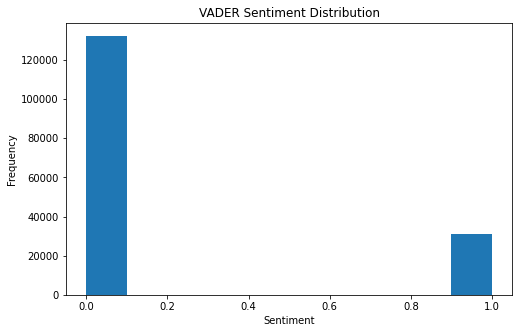

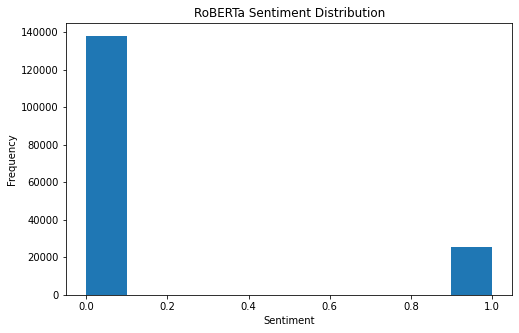

time: 324 ms (started: 2022-12-12 21:03:46 +00:00)


In [ ]:
# Frequency distribution for classes : VADER
plt.figure(figsize=(8,5))
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.hist(tweets['vader_sent'])
plt.title('VADER Sentiment Distribution')
plt.show()

# Frequency distribution for classes : RoBERTa
plt.figure(figsize=(8,5))
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.hist(tweets['roberta_sent'])
plt.title('RoBERTa Sentiment Distribution')
plt.show()

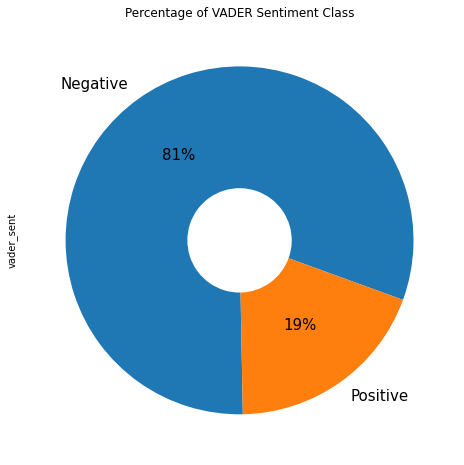

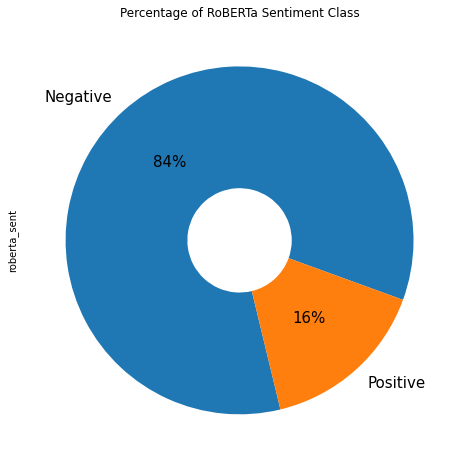

time: 155 ms (started: 2022-12-12 21:03:51 +00:00)


In [ ]:
# Pie Chart CLass Distributions
plt.figure(figsize=(8,8))
plt.title('Percentage of VADER Sentiment Class')
tweets.vader_sent.value_counts().plot(kind='pie', labels=['Negative', 'Positive'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})
plt.show()

plt.figure(figsize=(8,8))
plt.title('Percentage of RoBERTa Sentiment Class')
tweets.roberta_sent.value_counts().plot(kind='pie', labels=['Negative', 'Positive'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})
plt.show()

In [ ]:
tweets.head(2)

,text,lemm_tokens,vader_sent,roberta_sent
0,utterly shocked and saddened by this youth icons murder,"[utterly, shocked, saddened, youth, icon, murder]",0,0
1,this murder case should be handover to cbi enquirybecause state government order to pull back se...,"[murder, case, handover, cbi, enquirybecause, state, government, order, pull, back, security, op...",0,0


time: 7.36 ms (started: 2022-12-12 21:04:00 +00:00)


In [ ]:
# tweets1.lemm_tokens = tweets1.lemm_tokens.to_list()
tweets['lemm_tokens'][0]

['utterly', 'shocked', 'saddened', 'youth', 'icon', 'murder']

time: 3.73 ms (started: 2022-12-12 21:04:05 +00:00)


In [ ]:
# Term Frequency Analysis
words = tweets['lemm_tokens']
allwords = []
for wordlist in words:
  allwords += wordlist

print(allwords[:50])

['utterly', 'shocked', 'saddened', 'youth', 'icon', 'murder', 'murder', 'case', 'handover', 'cbi', 'enquirybecause', 'state', 'government', 'order', 'pull', 'back', 'security', 'open', 'name', 'congress', 'youth', 'icon', 'hour', 'shot', 'dead', 'gangestar', 'pamicus', 'curia', 'life', 'cycled', 'state', 'hellion', 'fate', 'thrive', 'murder', 'fear', 'hate', 'life', 'find', 'exit', 'gate', 'life', 'begin', 'breath', 'youth', 'life', 'must', 'end', 'death', 'truth']
time: 106 ms (started: 2022-12-12 21:04:26 +00:00)


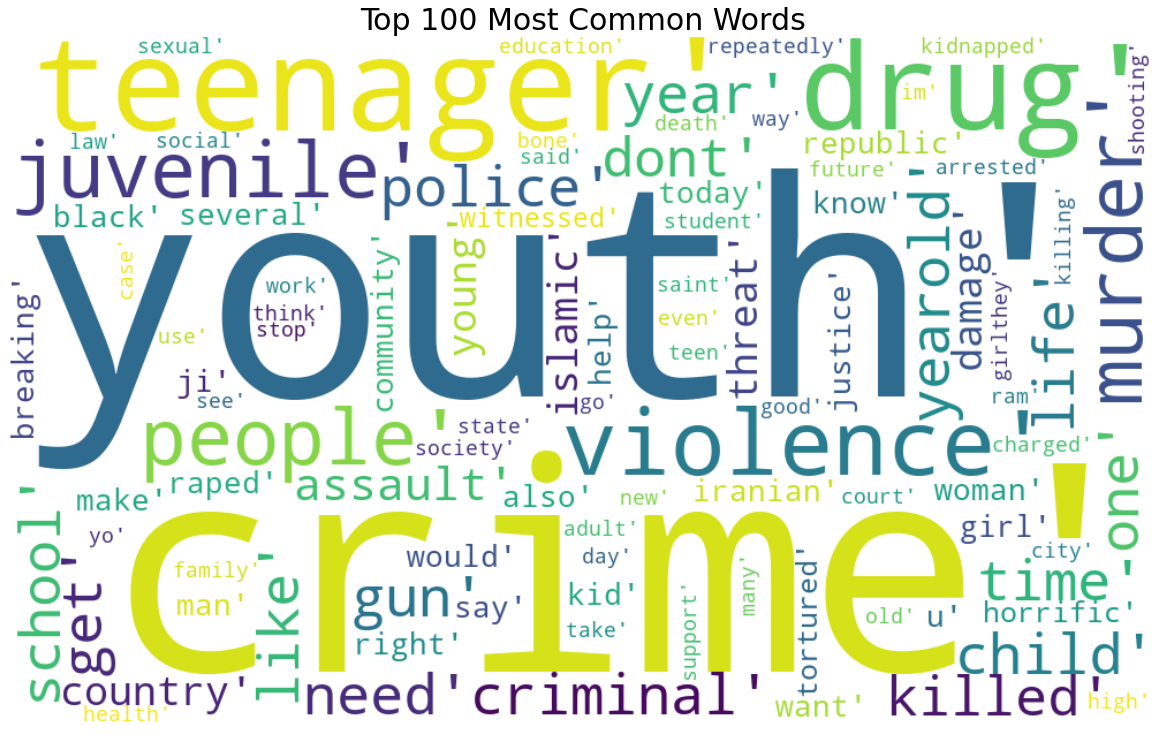

In [ ]:
# Most Common 100 Words
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(20,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=30)
plt.tight_layout(pad=0)
plt.show()

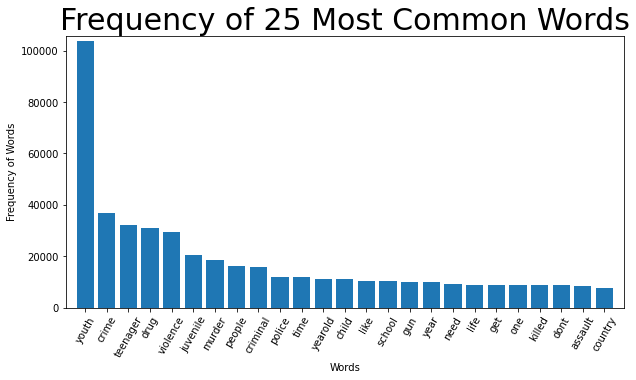

time: 1.92 s (started: 2022-12-12 21:04:36 +00:00)


In [ ]:
# Most Common 25 Words
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(10,5))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words')
plt.ylabel('Frequency of Words')
plt.yticks()
plt.xticks(rotation=60)
plt.title('Frequency of 25 Most Common Words', fontsize=30)
plt.show()

In [ ]:
# Topic Modelling with TF-IDF method
tweets['lemma_str'] = [' '.join(map(str,l)) for l in tweets['lemm_tokens']]

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(tweets['lemma_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aap,abandoned,abbott,abc,abduction,abiding,ability,abiy,able,abolition,...,yr,yrold,yup,zanu,zealand,zero,zimbabwe,zionist,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 6.44 s (started: 2022-12-12 21:05:15 +00:00)


In [ ]:
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

time: 987 µs (started: 2022-12-12 21:05:21 +00:00)


In [ ]:
#Non-Negative Matrix Factorization (NMF)
nmf = NMF(n_components=10, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


Topic 0:
yearold kidnapped girlthey repeatedly witnessed tortured bone horrific raped breaking
Topic 1:
youth violence crime gun people damage community like young dont
Topic 2:
girl matabane crimemec jb psychologically organizing pa abused doctor organized
Topic 3:
drug ji ram rahim gurmeet society youth saint today song
Topic 4:
therapistwe psychotherapy skipping licensed counselling schedule prey hanging crowd falling
Topic 5:
torturing crush begun continued protestors detained please student voice effort
Topic 6:
murder teenager charged arrested man assault police shooting yearold death
Topic 7:
supreme vulgarity bollywood listen future country depends easily knowledge taught
Topic 8:
seventeen yo girlthey kidnapped repeatedly witnessed tortured horrific raped breaking
Topic 9:
juvenile criminal justice delinquency crime record court adult system law
time: 14.5 s (started: 2022-12-12 21:05:21 +00:00)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
tweets.head(3)

,text,lemm_tokens,vader_sent,roberta_sent,lemma_str
0,utterly shocked and saddened by this youth icons murder,"[utterly, shocked, saddened, youth, icon, murder]",0,0,utterly shocked saddened youth icon murder
1,this murder case should be handover to cbi enquirybecause state government order to pull back se...,"[murder, case, handover, cbi, enquirybecause, state, government, order, pull, back, security, op...",0,0,murder case handover cbi enquirybecause state government order pull back security open name cong...
2,pamicus curiae if life is cycled in this state then it has the hellions fate to thrive in murder...,"[pamicus, curia, life, cycled, state, hellion, fate, thrive, murder, fear, hate, life, find, exi...",0,0,pamicus curia life cycled state hellion fate thrive murder fear hate life find exit gate life be...


time: 19.1 ms (started: 2022-12-12 21:05:36 +00:00)


# 5. Preparing data for Fine-tuning BERT (Approach I) model with Sentiment-140 dataset for Predictions on Twitter Dataset

## *i) Import Sentiment-140 Dataset for Fine-Training BERT model* 

In [ ]:
## Mount Google Drive to notebook
# from google.colab import drive
# drive.mount('/content/drive')

# Data Import and loading in Dataframe for Sentiment 140 training
path = r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Sentiment140_exp1/Sentiment140_train.csv'
tune_df = pd.read_csv(path)

time: 3.14 s (started: 2022-12-13 12:07:28 +00:00)


In [ ]:
# Updating Labels as 0 and 1
new_label = {4 : 1, 0: 0}
tune_df['Sentiment'] = tune_df['Sentiment'].map(new_label)
tune_df = tune_df[['text', 'Sentiment']]
tune_df.head()

,text,Sentiment
0,awww thats a bummer you shoulda got david carr of third day to do it,0
1,is upset that he cant update his facebook by texting it and might cry as a result school today also blah,0
2,i dived many times for the ball managed to save the rest go out of bounds,0
3,my whole body feels itchy and like its on fire,0
4,no its not behaving at all im mad why am i here because i cant see you all over there,0


time: 82.4 ms (started: 2022-12-13 12:07:31 +00:00)


In [ ]:
tune_df.isna().sum()

text         3218
Sentiment       0
dtype: int64

time: 146 ms (started: 2022-12-13 12:07:31 +00:00)


In [ ]:
tune_df.dropna(inplace=True)
tune_df.isna().sum()

text         0
Sentiment    0
dtype: int64

time: 270 ms (started: 2022-12-13 12:07:31 +00:00)


In [ ]:
tune_df.Sentiment.value_counts(normalize=True)

1    0.500332
0    0.499668
Name: Sentiment, dtype: float64

time: 12.5 ms (started: 2022-12-13 12:07:31 +00:00)


In [ ]:
tune_df_0 = tune_df[tune_df['Sentiment']== 0]
tune_df_0.Sentiment.value_counts()

0    788600
Name: Sentiment, dtype: int64

time: 41.3 ms (started: 2022-12-13 12:07:31 +00:00)


In [ ]:
tune_df_1 = tune_df[tune_df['Sentiment']== 1]

tune_df_1.Sentiment.value_counts()

1    789648
Name: Sentiment, dtype: int64

time: 40.3 ms (started: 2022-12-13 12:07:31 +00:00)


## *ii) Reducing the dataset for Faster Training (100k datapoints)* 


In [ ]:
tune_df = pd.concat([tune_df_0[:50000],tune_df_1[:50000]])
tune_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 840290
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       100000 non-null  object
 1   Sentiment  100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB
time: 14.7 ms (started: 2022-12-13 12:07:31 +00:00)


In [ ]:
tune_df.Sentiment.value_counts(normalize =True)

0    0.5
1    0.5
Name: Sentiment, dtype: float64

time: 5.84 ms (started: 2022-12-13 12:07:32 +00:00)


In [ ]:
tune_df.head()

,text,Sentiment
0,awww thats a bummer you shoulda got david carr of third day to do it,0
1,is upset that he cant update his facebook by texting it and might cry as a result school today also blah,0
2,i dived many times for the ball managed to save the rest go out of bounds,0
3,my whole body feels itchy and like its on fire,0
4,no its not behaving at all im mad why am i here because i cant see you all over there,0


time: 5.9 ms (started: 2022-12-13 12:07:33 +00:00)


## *iii) Preprocessing and saving tune_df* 

In [ ]:
def preprocess_dataset(df):
  # drop duplicates
  df_wo_dupe = df.drop_duplicates(subset = ['text'])

  #removing retweets labeled with RT in the text
  df1 = df_wo_dupe[~df_wo_dupe.text.str.startswith('RT')].reset_index(drop=['index'])

  # wordcount - filtering for less than 3 words
  import re
  # getting word counts for each tweet and removing posts with less than 4 words
  df1['WordsCount'] = df1['text'].apply(lambda x: len(re.findall(r'\w+',x)))
  df1 = df1[df1['WordsCount']>3]

  # Cleaning URLs, Mentions, Smileys and Restricted words (FAV, RT).
  import preprocessor as p
  df1['text'] = df1['text'].apply(lambda x: p.clean(x))

  #remove digits and making text lowercase for simplicity
  df1['text'] = df1['text'].str.replace('\d+', '')
  df1['text'] = df1['text'].str.lower()

  #removing punctuations
  import string
  df1['text'] = df1['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

  return df1

tune_df = preprocess_dataset(tune_df)

<ipython-input-50-f418e7e9c06a>:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['text'] = df1['text'].str.replace('\d+', '')


time: 6.52 s (started: 2022-12-13 12:07:41 +00:00)


In [ ]:
# Saving Preprocessed Sentiment 140 Dataset for Fine-tuning Bert
# tune_df.to_json(r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Sentiment140_exp1/Sentiment140_train_preprocessed.json')
tune_df.head()

,text,Sentiment,WordsCount
0,awww thats a bummer you shoulda got david carr of third day to do it,0,15
1,is upset that he cant update his facebook by texting it and might cry as a result school today also blah,0,21
2,i dived many times for the ball managed to save the rest go out of bounds,0,16
3,my whole body feels itchy and like its on fire,0,10
4,no its not behaving at all im mad why am i here because i cant see you all over there,0,20


time: 6.21 ms (started: 2022-12-13 12:07:47 +00:00)


In [ ]:
tune_df.shape

(92325, 3)

time: 3.38 ms (started: 2022-12-13 12:07:49 +00:00)


## *iv) Reading tune_df : Preprocessed Customized Sentiment-140 Dataset*

In [ ]:
# Read Sentiment-140 preprocessed dataset for Fine-tuning BERT
# tune_df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Sentiment140_exp1/Sentiment140_train_preprocessed.json')
tune_df.head(3)

,text,Sentiment,WordsCount
0,awww thats a bummer you shoulda got david carr...,0,15
1,is upset that he cant update his facebook by t...,0,21
2,i dived many times for the ball managed to sav...,0,16


time: 849 ms (started: 2022-12-13 11:47:48 +00:00)


# 6. Fine-Tuned Model Training

## *i) Reading tune_df : Preprocessed Customized Sentiment-140 Dataset*

In [ ]:
# Read Sentiment-140 preprocessed dataset for Fine-tuning BERT
# tune_df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Sentiment140_exp1/Sentiment140_train_preprocessed.json')
tune_df.head(3)

,text,Sentiment,WordsCount
0,awww thats a bummer you shoulda got david carr...,0,15
1,is upset that he cant update his facebook by t...,0,21
2,i dived many times for the ball managed to sav...,0,16


time: 1.47 s (started: 2022-12-14 21:00:27 +00:00)


In [ ]:
tune_df.shape

(92325, 3)

time: 2.31 ms (started: 2022-12-14 21:00:28 +00:00)


In [ ]:
tune_df.dropna(axis= 0,inplace= True)
tune_df.reset_index(inplace=True, drop='index')
tune_df.head(3)

,text,Sentiment,WordsCount
0,awww thats a bummer you shoulda got david carr...,0,15
1,is upset that he cant update his facebook by t...,0,21
2,i dived many times for the ball managed to sav...,0,16


time: 20.6 ms (started: 2022-12-14 21:00:28 +00:00)


In [ ]:
tune_df.shape

(92325, 3)

time: 2.38 ms (started: 2022-12-14 21:00:28 +00:00)


## *ii) Split train dataset into train, validation and test sets*

In [ ]:
# tune_df.isna().sum()

time: 307 µs (started: 2022-12-14 21:00:28 +00:00)


In [ ]:
# tune_df = tune_df[['text','Sentiment']]
print(tune_df.Sentiment.value_counts())

0    46850
1    45475
Name: Sentiment, dtype: int64
time: 2.89 ms (started: 2022-12-14 21:00:28 +00:00)


In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(tune_df['text'], tune_df['Sentiment'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=tune_df['Sentiment'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

time: 40.8 ms (started: 2022-12-14 21:00:28 +00:00)


In [ ]:
len(train_text)

64627

time: 2.17 ms (started: 2022-12-14 21:00:28 +00:00)


# *iii) Define Model Architecture for Fine-tuning (**epochs:)**) - Resume for predictions using saved model*

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Clears output cell post execution
clear_output(wait=False)

# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False
    
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict = False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# number of training epochs
epochs = 5


time: 1.88 s (started: 2022-12-14 21:01:15 +00:00)


## *iv) Tokenization*

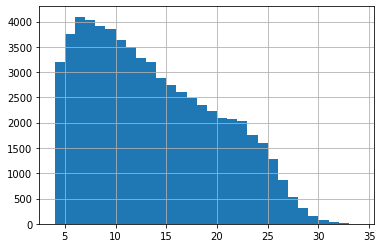

time: 333 ms (started: 2022-12-14 21:00:50 +00:00)


In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 20

time: 417 µs (started: 2022-12-14 21:00:51 +00:00)


In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


time: 2.36 s (started: 2022-12-14 21:00:51 +00:00)


## *v) Convert Sequences to Tensors*

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

time: 262 ms (started: 2022-12-14 21:00:53 +00:00)


## *vi) Create DataLoaders*

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
# batch_size = 32
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

time: 1.5 ms (started: 2022-12-14 21:00:53 +00:00)


## *vii) Find Class Weights, define Loss*

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight ='balanced', \
                                 classes= np.unique(train_labels), \
                                 y=train_labels)

print(class_wts)

[0.98531788 1.01512629]
time: 11.1 ms (started: 2022-12-14 21:00:53 +00:00)


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

time: 1.85 ms (started: 2022-12-14 21:00:53 +00:00)


## *viii) Fine-Tune BERT Trainer definition*

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 150 batches.
    if step % 500 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss and accuracy
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()
  
    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.cpu().detach().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss and accuracy of the epoch
  avg_loss = total_loss / len(train_dataloader)
  # avg_acc = total_accuracy / len(train_dataloader)     # accuracy testing

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

  # function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 500 batches.
    if step % 500 == 0 and not step == 0:
              
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss and accuracy between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()
    
      # acc = accuracy_score(labels,preds)
      # total_accuracy = total_accuracy + acc.item()

      total_preds.append(preds)

  # compute the validation loss and accuracy of the epoch
  avg_loss = total_loss / len(val_dataloader) 
  # avg_acc = total_accuracy / len(train_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

time: 3.35 ms (started: 2022-12-14 21:00:53 +00:00)


## *ix) Initiate Training*

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss and accuracy of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

        # Model for epoch 10
        # torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Models/Model_FT_BERT_Sentiment140_ep10_GPU.pt')
        
        # Change epochs in Model Definintion section (6.iii) and uncomment below to run for 5 epochs
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Models/Model_FT_BERT_Sentiment140_ep5_GPU.pt')

    # append training and validation loss and accuracy
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch   500  of  2,020.
  Batch 1,000  of  2,020.
  Batch 1,500  of  2,020.
  Batch 2,000  of  2,020.

Evaluating...

Training Loss: 0.608
Validation Loss: 0.545

 Epoch 2 / 5
  Batch   500  of  2,020.
  Batch 1,000  of  2,020.
  Batch 1,500  of  2,020.
  Batch 2,000  of  2,020.

Evaluating...

Training Loss: 0.574
Validation Loss: 0.564

 Epoch 3 / 5
  Batch   500  of  2,020.
  Batch 1,000  of  2,020.
  Batch 1,500  of  2,020.
  Batch 2,000  of  2,020.

Evaluating...

Training Loss: 0.568
Validation Loss: 0.543

 Epoch 4 / 5
  Batch   500  of  2,020.
  Batch 1,000  of  2,020.
  Batch 1,500  of  2,020.
  Batch 2,000  of  2,020.

Evaluating...

Training Loss: 0.564
Validation Loss: 0.601

 Epoch 5 / 5
  Batch   500  of  2,020.
  Batch 1,000  of  2,020.
  Batch 1,500  of  2,020.
  Batch 2,000  of  2,020.

Evaluating...

Training Loss: 0.559
Validation Loss: 0.529
time: 3min 19s (started: 2022-12-14 21:01:21 +00:00)


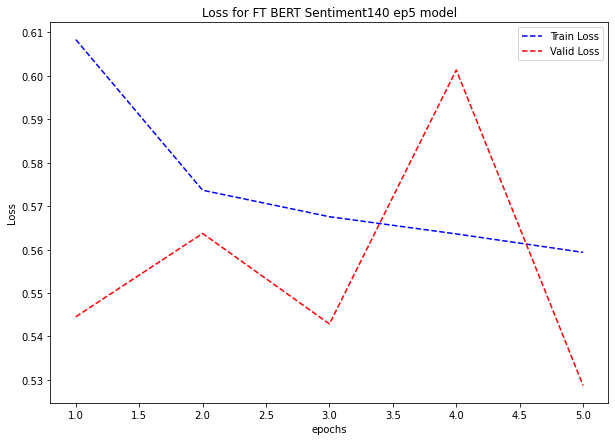

<Figure size 432x288 with 0 Axes>

time: 259 ms (started: 2022-12-14 21:04:40 +00:00)


In [ ]:
#Plotting Model Loss
import matplotlib.pyplot as plt

# x is no of epochs
x = np.arange(epochs)+1

plt.figure(figsize = (10,7))
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.title('Loss for FT BERT Sentiment140 ep5 model')
plt.plot(x, train_losses, 'b--', label = 'Train Loss')
plt.plot(x, valid_losses, 'r--', label = 'Valid Loss')
plt.legend()

plt.show()

# Change names for model-wise outputs
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/Loss_for_FT_BERT_Sentiment140_ep5_model.png')

## *x) Load Saved Model*

In [ ]:
# #load weights of best model (choose model variant by changing ep5)
# path = '/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Models/Model_FT_BERT_Sentiment140_ep5_GPU.pt'

# for ep10 model
path = '/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Models/Model_FT_BERT_Sentiment140_ep10_GPU.pt'

model.load_state_dict(torch.load(path))

<All keys matched successfully>

time: 495 ms (started: 2022-12-14 18:28:30 +00:00)


# 7. Predictions on Sentiment 140 Test Dataset

In [ ]:
## Clears CUDA memory
# torch.cuda.empty_cache()

# #load weights of best model
path = '/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Models/Model_FT_BERT_Sentiment140_ep5_GPU.pt'

# for ep10 model
# path = '/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Models/Model_FT_BERT_Sentiment140_ep10_GPU.pt'

model.load_state_dict(torch.load(path))

<All keys matched successfully>

time: 552 ms (started: 2022-12-14 21:04:40 +00:00)


In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

time: 3.13 s (started: 2022-12-14 21:04:41 +00:00)


In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print('Scores_FT_BERT_Sentiment140_ep5_test\n')
print(classification_report(test_y, preds))


Scores_FT_BERT_Sentiment140_ep5_test

              precision    recall  f1-score   support

           0       0.72      0.79      0.75      7028
           1       0.76      0.68      0.72      6821

    accuracy                           0.73     13849
   macro avg       0.74      0.73      0.73     13849
weighted avg       0.74      0.73      0.73     13849

time: 25.7 ms (started: 2022-12-14 21:04:44 +00:00)


In [ ]:
# # model's performance for ep10 model
# preds = np.argmax(preds, axis = 1)
# print('Scores_FT_BERT_Sentiment140_ep10_test\n')
# print(classification_report(test_y, preds))


str

time: 3.49 ms (started: 2022-12-13 14:18:05 +00:00)


In [ ]:
# confusion matrix
cfm =pd.crosstab(test_y, preds)
cfm.astype('int32')

col_0,0,1
row_0,,
0,5548,1480
1,2190,4631


time: 24.7 ms (started: 2022-12-14 21:04:44 +00:00)


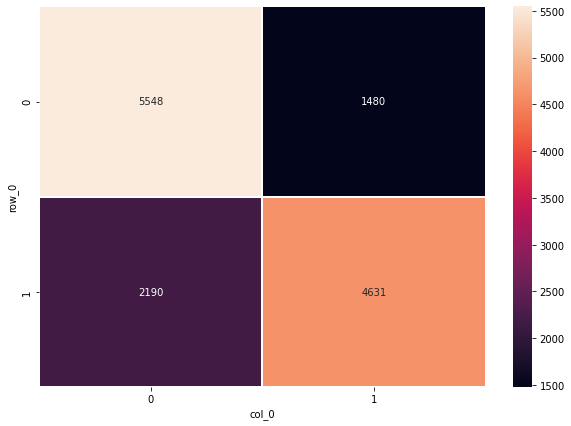

time: 259 ms (started: 2022-12-14 21:07:36 +00:00)


In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

df_cfm = pd.DataFrame(cfm)
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot =True, linewidths =1, fmt='g')

# Save confusion matrix
# cfm_plot.figure.savefig\
# ('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/CFM_FT_BERT_Sentiment140_ep5_test.png')

In [ ]:
# Saving predictions for later use to get Metrics Scores
# pd.DataFrame(preds).to_csv(r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Embeddings_and_Preds/Preds_FT_BERT_Sentiment140_ep5_test.csv')

# Save for ep10 model
# pd.DataFrame(preds).to_csv(r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Embeddings_and_Preds/Preds_FT_BERT_Sentiment140_ep10_test.csv')


time: 24.9 ms (started: 2022-12-12 21:19:57 +00:00)


# 8. Predicting on Twitter Dataset using Fine-Tuned BERT (Sentiment140)


In [ ]:
torch.cuda.empty_cache()

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.metrics import roc_curve, auc

# #load weights of best model
# path = '/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Models/Model_FT_BERT_Sentiment140_ep5_GPU.pt'

# for ep10 model
# path = '/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Models/Model_FT_BERT_Sentiment140_ep10_GPU.pt'

# model.load_state_dict(torch.load(path))

# load Twitter Dataset for Testing performance
path = r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Benchmark_Twitter/Benchmark_Twitter_Labels.json'
twitter_df = pd.read_json(path)
twitter_df = twitter_df[['text','roberta_sent']]

twitter_df.rename(columns ={'roberta_sent': 'label'}, inplace=True)
twitter_df.head()

,text,label
0,utterly shocked and saddened by this youth ico...,0
1,this murder case should be handover to cbi enq...,0
2,pamicus curiae if life is cycled in this state...,0
3,last year in august sad youth leader vikramjit...,0
4,i am shocked at murder of siddhu moosawala hea...,0


time: 1.68 s (started: 2022-12-14 21:57:03 +00:00)


In [ ]:
twitter_df.isna().any()
# twitter_df.dropna(inplace=True)

text     False
label    False
dtype: bool

time: 19.3 ms (started: 2022-12-14 21:57:08 +00:00)


In [ ]:
twitter_df.label.value_counts()

0    137984
1     25642
Name: label, dtype: int64

time: 5.13 ms (started: 2022-12-14 21:57:08 +00:00)


In [ ]:
# Downsizing data for testing due to CUDA memory limitation

# Negative Labels count
twitter_df_0 = twitter_df[twitter_df['label'] == 0]
print(twitter_df_0.label.value_counts())
# Positive Labels count
twitter_df_1 = twitter_df[twitter_df['label'] == 1]
print(twitter_df_1.label.value_counts())

0    137984
Name: label, dtype: int64
1    25642
Name: label, dtype: int64
time: 16.3 ms (started: 2022-12-14 21:57:09 +00:00)


In [ ]:
twitter_df = pd.concat([twitter_df_0[:7000],twitter_df_1[:7000]])
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14000 entries, 0 to 43235
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14000 non-null  object
 1   label   14000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 328.1+ KB
time: 10.2 ms (started: 2022-12-14 21:57:11 +00:00)


In [ ]:
# Fix twitter_text , twitter_y for model predictions
twitter_text = twitter_df['text']
twitter_labels = twitter_df['label']

time: 552 µs (started: 2022-12-14 21:57:12 +00:00)


In [ ]:
# Change test_text, test_y, test_mask
max_seq_len = 20

tokens_twitter_test = tokenizer.batch_encode_plus(
    twitter_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# for twitter test set
test_seq = torch.tensor(tokens_twitter_test['input_ids'])
test_mask = torch.tensor(tokens_twitter_test['attention_mask'])
test_y = torch.tensor(twitter_labels.tolist())

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


time: 646 ms (started: 2022-12-14 21:57:13 +00:00)


In [ ]:
# get predictions for twitter data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))

  preds_twitter = preds.detach().cpu().numpy()

time: 3.15 s (started: 2022-12-14 21:57:16 +00:00)


In [ ]:
# model's predictions and performance on Twitter Dataset 
preds_twitter = np.argmax(preds_twitter, axis = 1)
print(classification_report(test_y, preds_twitter))

# confusion matrix
print(pd.crosstab(test_y, preds_twitter))

# Saving predictions for Metrics Scores
# Saving predictions for later use to get Metrics Scores
# pd.DataFrame(preds_twitter).to_csv(r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Embeddings_and_Preds/Preds_FT_BERT_Senitment140_ep5_for_Twitter.csv')

# Save for ep10 model
# pd.DataFrame(preds_twitter).to_csv(r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Embeddings_and_Preds/Preds_FT_BERT_Senitment140_ep10_for_Twitter.csv')


              precision    recall  f1-score   support

           0       0.72      0.73      0.73      7000
           1       0.73      0.72      0.72      7000

    accuracy                           0.72     14000
   macro avg       0.72      0.72      0.72     14000
weighted avg       0.72      0.72      0.72     14000

col_0     0     1
row_0            
0      5134  1866
1      1986  5014
time: 35 ms (started: 2022-12-14 21:57:32 +00:00)


In [ ]:
# confusion matrix
cfm =pd.crosstab(test_y, preds_twitter)
cfm.astype('int32')

col_0,0,1
row_0,,
0,5134,1866
1,1986,5014


time: 15.9 ms (started: 2022-12-14 21:57:37 +00:00)


<bound method Figure.savefig of <Figure size 720x504 with 2 Axes>>

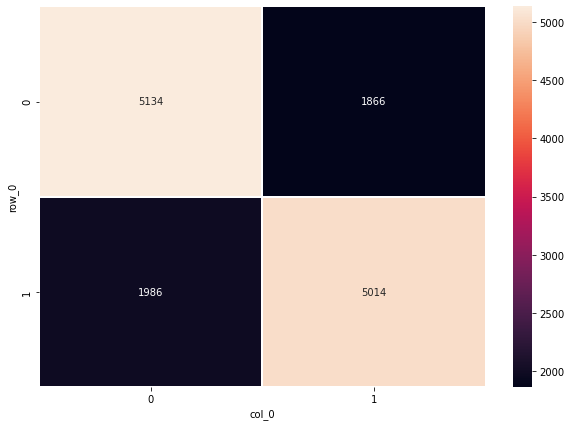

time: 184 ms (started: 2022-12-14 21:57:40 +00:00)


In [ ]:
# Save Confusion Matrix

import seaborn as sn
import matplotlib.pyplot as plt

df_cfm = pd.DataFrame(cfm)
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot =True, linewidths =1, fmt ='g')

# Save confusion matrix
cfm_plot.figure.savefig\
# ('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/CFM_FT_BERT_Sentiment140_ep5_for_Twitter.png')

In [ ]:
# twitter_df.rename(columns={'FT_BERT_sentiment140_label': 'label2'},inplace=True)
twitter_df['label2'] = preds_twitter
twitter_df.head()

,text,label,label2
0,utterly shocked and saddened by this youth ico...,0,0
1,this murder case should be handover to cbi enq...,0,0
2,pamicus curiae if life is cycled in this state...,0,1
3,last year in august sad youth leader vikramjit...,0,0
4,i am shocked at murder of siddhu moosawala hea...,0,0


time: 6.97 ms (started: 2022-12-14 18:29:18 +00:00)


In [ ]:
# Save final Twitter Data with labels from approach 1
twitter_df.to_json('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/Twitter14k_FT_BERT_Sentiment140_ep5.json')

# Save for ep10 model
# twitter_df.to_json('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/Twitter14k_FT_BERT_Sentiment140_ep10.json')

twitter_df.tail(10)

,text,label,label2
43181,very good team jhunjhunuwe trust in our new yo...,1,1
43192,lets tackle crime by making investments in spo...,1,0
43198,did you know early childhood intervention is a...,1,1
43208,well see you at the charles young park today a...,1,1
43219,just finished about a hard line judge sentenci...,1,1
43222,saturday bringing people together to pray and ...,1,1
43224,inorder to save youth from falling prey to dru...,1,1
43233,great to see the team down at sharing informat...,1,1
43234,reflecting on forgiveness and the need to stan...,1,1
43235,the groom in the front is likely going to be a...,1,1


time: 364 ms (started: 2022-12-14 18:29:18 +00:00)


# 9. Results on Twitter 14k Dataset Using Fine-tuned BERT model (Approach I)

In [ ]:
# twitter_df = pd.read_json(r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/Twitter14k_FT_BERT_Sentiment140_ep5.json')

# OR 
# twitter_df = pd.read_json(r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/Twitter14k_FT_BERT_Sentiment140_ep10.json')

twitter_df.head(10)

,text,label
0,utterly shocked and saddened by this youth ico...,0
1,this murder case should be handover to cbi enq...,0
2,pamicus curiae if life is cycled in this state...,0
3,last year in august sad youth leader vikramjit...,0
4,i am shocked at murder of siddhu moosawala hea...,0
7,teenagerit is legal for a year old to walk in...,0
8,even if that were the case wed still have a sy...,0
9,man if you own a gun shop and you are confront...,0
10,unlike most spheres of drugs youth overdose is...,0
11,whole generations of maldivian youth r lost in...,0


time: 6.69 ms (started: 2022-12-14 21:40:30 +00:00)


In [ ]:
twitter_df.label.value_counts()

0    7000
1    7000
Name: label, dtype: int64

time: 4.75 ms (started: 2022-12-12 21:38:25 +00:00)


In [ ]:
twitter_df.label2.value_counts()

0    9489
1    4511
Name: label2, dtype: int64

time: 3.9 ms (started: 2022-12-12 21:38:38 +00:00)


# 10. BERT Embeddings extracted for RF, SVC Classification (Approach II)

Model Training using BERT embeddings for Twitter 14k dataset using RandomForest Classifier

### Import Twitter 14k Dataset

In [ ]:
# Empty CUDA memory 
torch.cuda.empty_cache()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Twitter 14k dataset
# twitter_df = pd.read_json(r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/Twitter14k_FT_BERT_Sentiment140_ep5.json')

# OR
# twitter_df = pd.read_json(r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/Twitter14k_FT_BERT_Sentiment140_ep10.json')

twitter_df.head()


,text,label
0,utterly shocked and saddened by this youth ico...,0
1,this murder case should be handover to cbi enq...,0
2,pamicus curiae if life is cycled in this state...,0
3,last year in august sad youth leader vikramjit...,0
4,i am shocked at murder of siddhu moosawala hea...,0


time: 5.81 ms (started: 2022-12-14 21:22:09 +00:00)


In [ ]:
twitter_df.shape

(14000, 2)

time: 2.97 ms (started: 2022-12-14 21:40:37 +00:00)


### Feature Engineering Using BERT model embeddings

In [ ]:
# Approach 2 FEATURE EXTRACTION METHOD WITH ML MODEL

from transformers import BertModel, BertTokenizer, BertTokenizerFast 
import torch

model_name = 'bert-base-uncased'
model = BertModel.from_pretrained(model_name, output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained(model_name)

print('Module %s loaded for feature engineering!!! ' % model_name,'\n')

data = twitter_df['text']
# data = data.to_list()

batch_size =32

X = np.empty((batch_size, 768), int)

for idx in range(0, len(data), batch_size):
  batch = data[idx:min(len(data),idx+batch_size)]
  encoded_tokens = tokenizer.batch_encode_plus(batch, max_length = 20, padding = 'max_length', truncation =True)
  encoded = {key: torch.LongTensor(value) for key,value in encoded_tokens.items()}

  with torch.no_grad():
    outputs = model(**encoded)
    X = np.append(X, outputs['pooler_output'], axis=0)

# Features extracted from BERT model
training_features = X[batch_size:,:]
# print(training_features)

In [ ]:
# Save BERT Embeddings
pd.DataFrame(training_features).to_csv('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Embeddings_and_Preds/Bert_Embedding_features_Twitter14k.csv')
clear_output(wait=False)

time: 16.3 s (started: 2022-12-13 14:46:33 +00:00)


In [ ]:
training_features.shape

(14000, 769)

time: 2.6 ms (started: 2022-12-14 21:44:57 +00:00)


In [ ]:
twitter_df.label.shape

(14000,)

time: 3.63 ms (started: 2022-12-14 21:45:31 +00:00)


### Model Training and Scores

In [ ]:
# Read BERT embeddings
training_features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Embeddings_and_Preds/Bert_Embedding_features_Twitter14k.csv')


time: 2.38 s (started: 2022-12-14 21:22:11 +00:00)


In [ ]:
# Implementing ML algos on BERT embeddings as features and train_labels as target values
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 
mdl_svc = SVC(probability=True,random_state = 100)

mdl = RandomForestClassifier(n_estimators =1000, random_state = 100, max_depth = 10, n_jobs =-1)

time: 826 µs (started: 2022-12-14 21:22:14 +00:00)


In [ ]:
Xtrain, Xtemp, ytrain, ytemp = train_test_split(training_features, twitter_df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=twitter_df['label'])

# we will use temp sets to create validation and test set
Xval, Xtest, yval, ytest = train_test_split(Xtemp, ytemp, random_state=2018, test_size=0.5,stratify=ytemp)

time: 61.7 ms (started: 2022-12-14 21:22:14 +00:00)


In [ ]:
# Model training
mdl.fit(Xtrain,ytrain)
mdl_svc.fit(Xtrain,ytrain)

SVC(probability=True, random_state=100)

time: 31.2 s (started: 2022-12-14 21:22:16 +00:00)


In [ ]:
# Classification Scores on Validation set
preds = mdl.predict(Xval)
preds_svc = mdl_svc.predict(Xval)

print('RandomForest Scores: \n', classification_report(yval, preds))

print('SVC Scores: \n', classification_report(yval, preds_svc))

RandomForest Scores: 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1050
           1       0.97      0.97      0.97      1050

    accuracy                           0.97      2100
   macro avg       0.97      0.97      0.97      2100
weighted avg       0.97      0.97      0.97      2100

SVC Scores: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1050
           1       1.00      1.00      1.00      1050

    accuracy                           1.00      2100
   macro avg       1.00      1.00      1.00      2100
weighted avg       1.00      1.00      1.00      2100

time: 1.06 s (started: 2022-12-14 21:22:47 +00:00)


In [ ]:
# Classification Scores on Test set
preds_test = mdl.predict(Xtest)
preds_test_svc = mdl_svc.predict(Xtest)

# print(classification_report(ytest, preds_test))
print('RandomForest Scores: \n', classification_report(ytest, preds_test))

print('SVC Scores: \n', classification_report(ytest, preds_test_svc))

RandomForest Scores: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1050
           1       0.98      0.98      0.98      1050

    accuracy                           0.98      2100
   macro avg       0.98      0.98      0.98      2100
weighted avg       0.98      0.98      0.98      2100

SVC Scores: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1050
           1       1.00      1.00      1.00      1050

    accuracy                           1.00      2100
   macro avg       1.00      1.00      1.00      2100
weighted avg       1.00      1.00      1.00      2100

time: 1.08 s (started: 2022-12-14 21:22:48 +00:00)


In [ ]:
# Saving test predictions for later use to get Metrics Scores
pd.DataFrame(preds_test).to_csv(r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Embeddings_and_Preds/Preds_RF_bert_Twitter14k_test.csv')
pd.DataFrame(preds_test).to_csv(r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Embeddings_and_Preds/Preds_SVC_bert_Twitter14k_test.csv')

time: 529 ms (started: 2022-12-13 14:50:12 +00:00)


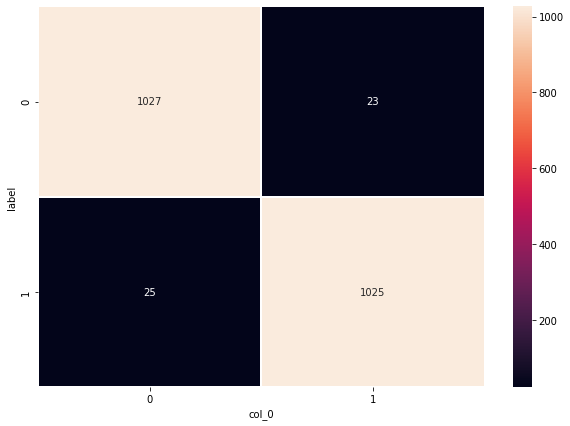

time: 178 ms (started: 2022-12-14 21:22:50 +00:00)


In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

# confusion matrix
cfm =pd.crosstab(ytest, preds_test)
cfm.astype('int32')

df_cfm = pd.DataFrame(cfm)
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot =True, linewidths =1, fmt='g')



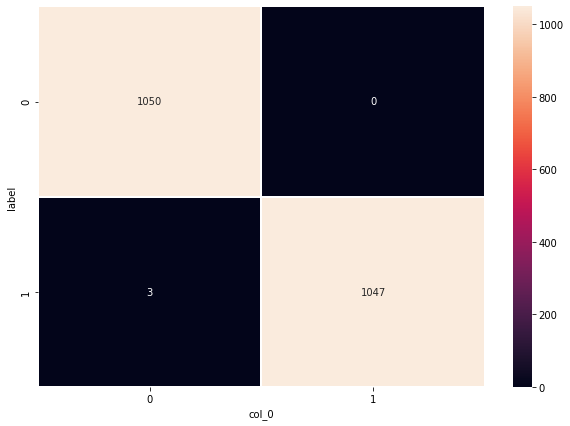

time: 204 ms (started: 2022-12-14 21:22:57 +00:00)


In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

# confusion matrix
cfm =pd.crosstab(ytest, preds_test_svc)
cfm.astype('int32')

df_cfm = pd.DataFrame(cfm)
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot =True, linewidths =1, fmt='g')



In [ ]:
import pickle
# save the model
filename = '/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Models/Model_RF_bert_Twitter14k.sav'
pickle.dump(model, open(filename, 'wb'))

filename_svc = '/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Models/Model_SVC_bert_Twitter14k.sav'
pickle.dump(model, open(filename_svc, 'wb'))

# load the model 
# loaded_model = pickle.load(open(filename, 'rb'))

# result = loaded_model.score(X_test, Y_test)


time: 9.84 s (started: 2022-12-13 14:50:14 +00:00)


AUC for RF classifier is: 0.9020897959183674


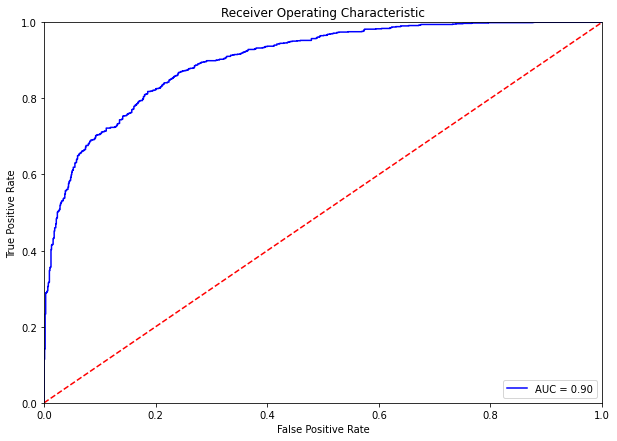

AUC for SVC classifier is: 0.9065773242630386


<Figure size 432x288 with 0 Axes>

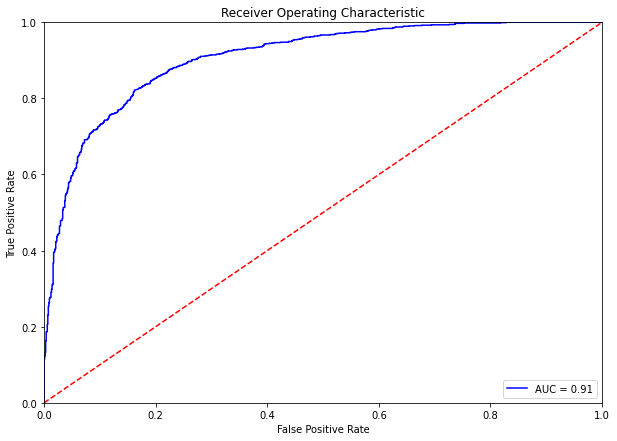

<Figure size 432x288 with 0 Axes>

time: 6.74 s (started: 2022-12-13 14:57:29 +00:00)


In [ ]:
# Metrics for RF 
# Importing all necessary libraries
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class_probabilities = mdl.predict_proba(Xtest)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)

# Printing AUC
print(f"AUC for RF classifier is: {roc_auc}")

# Plotting the ROC
plt.figure(figsize = (10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig\
('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/ROC_AUC_Twitter14k_RF_bert.png')

# ROC for SVC
class_probabilities = mdl_svc.predict_proba(Xtest)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)

# Printing AUC
print(f"AUC for SVC classifier is: {roc_auc}")

# Plotting the ROC
plt.figure(figsize = (10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig\
('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/ROC_AUC_Twitter14k_SVC_bert.png')


In [ ]:
# Adding RF_bert_labels and SVC bert labels as label3 and label4
preds = mdl.predict(training_features)

preds_svc = mdl_svc.predict(training_features)
twitter_df['label3'] = preds
twitter_df['label4'] = preds_svc
twitter_df.head()

,text,label,label2,label3,label4
0,utterly shocked and saddened by this youth icons murder,0,0,0,0
1,this murder case should be handover to cbi enquirybecause state government order to pull back security and open the name of congress youth icon and just before hours he is shot dead by a gangestar,0,0,0,0
2,pamicus curiae if life is cycled in this state then it has the hellions fate to thrive in murder fear amp hate for life can find no exit gate life begins with breath amp youth life must end with death amp truth by our creator with rights endowed born equal amp free,0,1,0,0
3,last year in august sad youth leader vikramjit singh alias vicky middhukhera was shot dead at mohali in parmish verma was shot in mohali under congress government sidhumoosewala murder got attention because he was a famous singer and recently entered politics,0,0,1,1
4,i am shocked at murder of siddhu moosawala heard him sing in melbourne years back and then he veered towards khalistani propagandareally sad at a young life lost who could have done something by being a good example for youth,0,0,0,0


time: 41.3 s (started: 2022-12-13 14:52:28 +00:00)


In [ ]:
twitter_df.shape

(14000, 5)

time: 2.45 ms (started: 2022-12-13 14:53:13 +00:00)


In [ ]:
# Saving twitter 14k dataset with added labels
twitter_df.to_json(r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/Twitter14k_RF_SVM_bert.json')

time: 25.8 ms (started: 2022-12-13 14:53:37 +00:00)
